In [1]:
# Importing necessary libraries
import torch    
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

Pre-processing of the given dataset

In [2]:
df = pd.read_csv('dataset/card_transaction.v1.csv')

In [3]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,NaN,No


In [4]:
dfLenOG = len(df)

#### Checking the stats of the dataset

In [5]:
df.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.555190e+06,2.555190e+06,2.555190e+06,2.555190e+06,2.555190e+06,2.555189e+06,2.216985e+06,2.555189e+06
mean,1.020676e+02,1.238151e+00,2.011793e+03,6.520146e+00,1.571605e+01,-5.783186e+17,5.306903e+04,5.563812e+03
std,6.215434e+01,1.344876e+00,5.150918e+00,3.470954e+00,8.790976e+00,4.731351e+18,2.851758e+04,8.973669e+02
min,0.000000e+00,0.000000e+00,1.995000e+03,1.000000e+00,1.000000e+00,-9.222265e+18,1.001000e+03,1.711000e+03
25%,4.800000e+01,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.693980e+18,3.053500e+04,5.300000e+03
50%,1.010000e+02,1.000000e+00,2.012000e+03,7.000000e+00,1.600000e+01,-9.844448e+17,4.837500e+04,5.499000e+03
75%,1.560000e+02,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.102660e+18,7.863300e+04,5.813000e+03
max,2.150000e+02,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.222877e+18,9.992800e+04,9.402000e+03


Finding NA value count in each column

In [6]:
df.isna().sum()

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  1
Use Chip                1
Merchant Name           1
Merchant City           1
Merchant State     321041
Zip                338205
MCC                     1
Errors?           2515428
Is Fraud?               1
dtype: int64

Upon inspection, The NA value count in `Errors?` column is very high. Calculating the percentage of NA values in `Errors?` column

In [7]:
df['Errors?'].isna().sum()/len(df)

0.9844387305836356

`Errors?` column has >98% NA values, dropping it

In [8]:
df = df.drop(['Errors?'], axis=1)

In [9]:
df.isna().sum()

User                   0
Card                   0
Year                   0
Month                  0
Day                    0
Time                   0
Amount                 1
Use Chip               1
Merchant Name          1
Merchant City          1
Merchant State    321041
Zip               338205
MCC                    1
Is Fraud?              1
dtype: int64

Checking for the 1 NA value in the ```Amount``` column to drop it

In [10]:
df['Amount'][df['Amount'].isnull()].index

Index([2555189], dtype='int64')

In [11]:
df = df.drop(index=[2555189])

In [12]:
df.isna().sum()

User                   0
Card                   0
Year                   0
Month                  0
Day                    0
Time                   0
Amount                 0
Use Chip               0
Merchant Name          0
Merchant City          0
Merchant State    321040
Zip               338204
MCC                    0
Is Fraud?              0
dtype: int64

Upon dropping the row 2555189, the NA values in `Amount`, `Use Chip`, `Merchant Name`, `Merchant City`, `MCC` and `Is Fraud?` became 0. This implies that the row 2555189 was containing all null values

In [13]:
df['Merchant State'].unique()

array(['CA', nan, 'NE', 'IL', 'MO', 'Switzerland', 'IA', 'TX', 'Estonia',
       'NJ', 'NV', 'NY', 'Japan', 'AZ', 'UT', 'FL', 'MI', 'Mexico', 'WA',
       'OH', 'Dominican Republic', 'NM', 'China', 'SC', 'AK', 'PA', 'VA',
       'Portugal', 'HI', 'CT', 'MA', 'MN', 'CO', 'Italy', 'GA',
       'Philippines', 'Jamaica', 'AR', 'Canada', 'OR', 'WI', 'NC',
       'France', 'WV', 'Norway', 'ME', 'NH', 'VT', 'MD', 'AL', 'KY', 'TN',
       'MS', 'New Zealand', 'Netherlands', 'KS', 'ND', 'DC',
       'Sierra Leone', 'Haiti', 'MT', 'South Korea', 'Spain', 'OK',
       'Algeria', 'Egypt', 'WY', 'ID', 'Indonesia', 'RI',
       'United Kingdom', 'Colombia', 'South Africa', 'IN', 'The Bahamas',
       'Singapore', 'Pakistan', 'Malaysia', 'Mongolia', 'Israel',
       'Hong Kong', 'Guatemala', 'Peru', 'Thailand', 'Sweden', 'Taiwan',
       'LA', 'Germany', 'Czech Republic', 'India', 'Poland', 'DE',
       'Costa Rica', 'Denmark', 'Bangladesh', 'Macedonia', 'Nigeria',
       'SD', 'Tuvalu', 'Ireland', '

In [14]:
df['Merchant State'].isna().sum()/len(df), df['Zip'].isna().sum()/len(df)

(0.12564236931201567, 0.13235968063419185)

Only 12-13% values were NA in `Merchant State` and `Zip` column. Dropping them!

In [15]:
df = df.dropna()

In [16]:
df.isna().sum()

User              0
Card              0
Year              0
Month             0
Day               0
Time              0
Amount            0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Is Fraud?         0
dtype: int64

In [17]:
len(df)/dfLenOG

0.867639979805807

After dropping all the NA value columns, we are still able to retain > 86% of the data

In [18]:
converted = []
for i in df['Time'].values:
    xs = i.replace(":","")
    if len(xs)>1:
        converted.append(int(xs))

In [19]:
df['Time_Num'] = converted

In [20]:
df = df.drop(['Time'],axis=1)

In [21]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num
0,0,0,2002,9,1,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,No,621
1,0,0,2002,9,1,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,642
2,0,0,2002,9,2,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,622
3,0,0,2002,9,2,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,No,1745
4,0,0,2002,9,3,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,No,623


In [22]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Amount             object
Use Chip           object
Merchant Name     float64
Merchant City      object
Merchant State     object
Zip               float64
MCC               float64
Is Fraud?          object
Time_Num            int64
dtype: object

In [23]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num
0,0,0,2002,9,1,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,No,621
1,0,0,2002,9,1,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,642
2,0,0,2002,9,2,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,622
3,0,0,2002,9,2,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,No,1745
4,0,0,2002,9,3,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,No,623


In [24]:
df['Amount'].unique()

array(['$134.09', '$38.48', '$120.34', ..., '$391.10', '$293.51',
       '$296.08'], dtype=object)

In [25]:
len(df['Amount'])

2216985

In [26]:
converted = []
for i in tqdm(df['Amount'].values):
    if type(i) == str:
        xs = i.strip('$')
        converted.append(float(xs))

100%|██████████| 2216985/2216985 [00:00<00:00, 4017769.24it/s]


In [27]:
converted = np.array(converted)

In [28]:
# df = df.drop(['AmountX'], axis=1)
df['AmountX'] = converted

In [29]:
df = df.drop(['Amount'], axis=1)

In [30]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,No,621,134.09
1,0,0,2002,9,1,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,642,38.48
2,0,0,2002,9,2,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,622,120.34
3,0,0,2002,9,2,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,No,1745,128.95
4,0,0,2002,9,3,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,No,623,104.71


In [31]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Use Chip           object
Merchant Name     float64
Merchant City      object
Merchant State     object
Zip               float64
MCC               float64
Is Fraud?          object
Time_Num            int64
AmountX           float64
dtype: object

Giving rest of the columns to Label Encoder

In [32]:
toEncode = ['Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Is Fraud?']

for i in toEncode:
    label_encoder = LabelEncoder()
    df[i] = label_encoder.fit_transform(df[i])

In [33]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,1,15108,3654,4,91750.0,5300.0,0,621,134.09
1,0,0,2002,9,1,1,10137,4552,4,91754.0,5411.0,0,642,38.48
2,0,0,2002,9,2,1,10137,4552,4,91754.0,5411.0,0,622,120.34
3,0,0,2002,9,2,1,14970,4552,4,91754.0,5651.0,0,1745,128.95
4,0,0,2002,9,3,1,17876,3654,4,91750.0,5912.0,0,623,104.71


In [34]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Use Chip            int64
Merchant Name       int64
Merchant City       int64
Merchant State      int64
Zip               float64
MCC               float64
Is Fraud?           int64
Time_Num            int64
AmountX           float64
dtype: object

In [35]:
na_count = df.isna().sum()

print("Columns with NA values and their counts:")
print(na_count)

Columns with NA values and their counts:
User              0
Card              0
Year              0
Month             0
Day               0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Is Fraud?         0
Time_Num          0
AmountX           0
dtype: int64


In [36]:
df.to_csv('dataset/Good_Final.csv')

## Reading the pre-processed dataset

In [37]:
df = pd.read_csv('dataset/Good_Final.csv',)

In [38]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,1,15108,3654,4,91750.0,5300.0,0,621,134.09
1,0,0,2002,9,1,1,10137,4552,4,91754.0,5411.0,0,642,38.48
2,0,0,2002,9,2,1,10137,4552,4,91754.0,5411.0,0,622,120.34
3,0,0,2002,9,2,1,14970,4552,4,91754.0,5651.0,0,1745,128.95
4,0,0,2002,9,3,1,17876,3654,4,91750.0,5912.0,0,623,104.71


In [39]:
len(list(df.columns))

14

In [40]:
len(df)

2216985

## Normalizing the values

Using Standard Scaler to normalize the values, as the assumption of VAE is that the latent space follows `Gaussian` distribution

In [41]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df.values)
normalized_dataframe = pd.DataFrame(normalized_data, columns=df.columns)

In [42]:
normalized_dataframe.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,0.822126,-0.097789,-1.191026,1.356391,-0.399476,-0.015361,-1.295325,1.111510
1,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.253902,-0.053743
2,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.293352,0.943931
3,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,0.797802,0.298392,-1.191026,1.356531,-0.002817,-0.015361,0.921802,1.048865
4,-1.667172,-0.932706,-1.867914,0.712584,-1.446775,0.630024,1.310027,-0.097789,-1.191026,1.356391,0.292135,-0.015361,-1.291380,0.753439


In [43]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,1,15108,3654,4,91750.0,5300.0,0,621,134.09
1,0,0,2002,9,1,1,10137,4552,4,91754.0,5411.0,0,642,38.48
2,0,0,2002,9,2,1,10137,4552,4,91754.0,5411.0,0,622,120.34
3,0,0,2002,9,2,1,14970,4552,4,91754.0,5651.0,0,1745,128.95
4,0,0,2002,9,3,1,17876,3654,4,91750.0,5912.0,0,623,104.71


In [44]:
df = normalized_dataframe

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
device

device(type='cuda')

## VAE

![VAE](images/vae_arch.png)

### Model Definition

In [47]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential
        (
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential
        (
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, input_dim),
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterize(mu, log_var)
        decoded = self.decoder(z)
        return decoded, mu, log_var

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data.values.astype(float)
        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [48]:
input_dim = len(df.columns)
hidden_dim = 1024
latent_dim = 128
lr = 1e-3
batch_size = 512
num_epochs = 25

vae = VAE(input_dim, latent_dim)

In [49]:
optimizer = optim.Adam(vae.parameters(), lr=lr)

custom_dataset = CustomDataset(df)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

![VAE](images/loss.png)

In [50]:
def loss_function(recon_x, x, mu, logvar):
    mse_loss = nn.MSELoss(reduction='sum')
    MSE = mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD.to(device)
    return MSE + KLD

In [51]:
vals = next(iter(dataloader))

In [52]:
vals.shape

torch.Size([512, 14])

In [53]:
vae = vae.to(device)

### Training Loop

In [20]:
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, data in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data.to(device))
        loss = loss_function(recon_batch.to(device), data.to(device), mu.to(device), logvar.to(device))
        loss.backward()
        total_loss += loss.detach().cpu().item()/batch_size
        optimizer.step()
    # if epoch%50==0:
    print('Epoch {}, Loss: {:.2f}'.format(epoch+1, total_loss / len(dataloader)))

4331it [00:10, 417.07it/s]


Epoch 1, Loss: 14.28


4331it [00:10, 423.04it/s]


Epoch 2, Loss: 10.45


4331it [00:10, 422.23it/s]


Epoch 3, Loss: 10.23


4331it [00:10, 423.89it/s]


Epoch 4, Loss: 10.19


4331it [00:10, 418.80it/s]


Epoch 5, Loss: 10.00


4331it [00:10, 420.62it/s]


Epoch 6, Loss: 9.95


4331it [00:10, 413.48it/s]


Epoch 7, Loss: 9.87


4331it [00:10, 414.59it/s]


Epoch 8, Loss: 9.88


4331it [00:10, 414.60it/s]


Epoch 9, Loss: 9.83


4331it [00:10, 416.41it/s]


Epoch 10, Loss: 9.82


4331it [00:10, 416.87it/s]


Epoch 11, Loss: 9.81


4331it [00:10, 421.23it/s]


Epoch 12, Loss: 9.90


4331it [00:10, 416.16it/s]


Epoch 13, Loss: 9.78


4331it [00:10, 411.51it/s]


Epoch 14, Loss: 9.79


4331it [00:10, 413.48it/s]

Epoch 15, Loss: 9.78


### Saving the model

In [21]:
f"{total_loss / len(dataloader):.2f}"

'9.78'

In [22]:
current_time = datetime.datetime.now()

In [23]:
root = 'models'

In [24]:
savePath = f'{root}/{str(current_time).split(".")[0]}-{total_loss / len(dataloader):.2f}-2X.pth'

In [25]:
savePath

'models/2024-04-21 03:09:27-0.07-2X.pth'

In [26]:
torch.save(vae.state_dict(), savePath)

### Loading the model

In [54]:
vae.load_state_dict(torch.load('models/2024-04-18 18:28:01-7.70-2X.pth'))

<All keys matched successfully>

In [55]:
len(df)

2216985

Sending the model to CPU to generate > 2 million samples as the GPU VRAM gets full

In [56]:
device = 'cpu'

In [57]:
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=256, out_features=128, bias=True)
  (fc_var): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, ou

## Generating Synthetic Data

In [58]:
num_samples = len(df)
z_samples = torch.randn(num_samples, 128)

with torch.no_grad():
    generated_data = vae.decoder(z_samples.to(device)).cpu().numpy()
generated_df = pd.DataFrame(generated_data, columns=df.columns)

In [59]:
generated_df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0.523296,1.009511,-1.429399,0.040224,0.284149,0.638723,-0.633378,-1.187820,-0.236394,-0.394712,-0.182744,-0.024715,1.377787,0.047769
1,1.166427,-0.251605,-0.573819,0.779219,0.983389,0.627997,1.225469,1.219392,-0.898502,0.234330,-0.097091,-0.011761,-0.386160,-0.322100
2,1.091526,-0.543507,0.394433,-0.849763,-1.058629,0.555304,0.558918,0.915053,-0.738094,-0.146854,-0.178912,-0.024250,-0.279386,-0.318427
3,1.144131,0.422239,0.368921,-0.833311,-0.179379,0.254277,-0.860949,0.657257,0.630991,-1.184758,0.551541,-0.015081,-0.329215,-0.028550
4,-0.581870,-0.379387,-0.454627,0.756972,-1.046694,0.610999,0.734733,0.983883,-1.152615,1.247961,-0.215834,0.000363,1.446201,0.079011


In [60]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,0.822126,-0.097789,-1.191026,1.356391,-0.399476,-0.015361,-1.295325,1.111510
1,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.253902,-0.053743
2,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.293352,0.943931
3,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,0.797802,0.298392,-1.191026,1.356531,-0.002817,-0.015361,0.921802,1.048865
4,-1.667172,-0.932706,-1.867914,0.712584,-1.446775,0.630024,1.310027,-0.097789,-1.191026,1.356391,0.292135,-0.015361,-1.291380,0.753439


In [61]:
len(df.columns)

14

In [62]:
generated_df.to_csv('dataset/generated_data_770.csv')

## Results

#### Comparison with original data

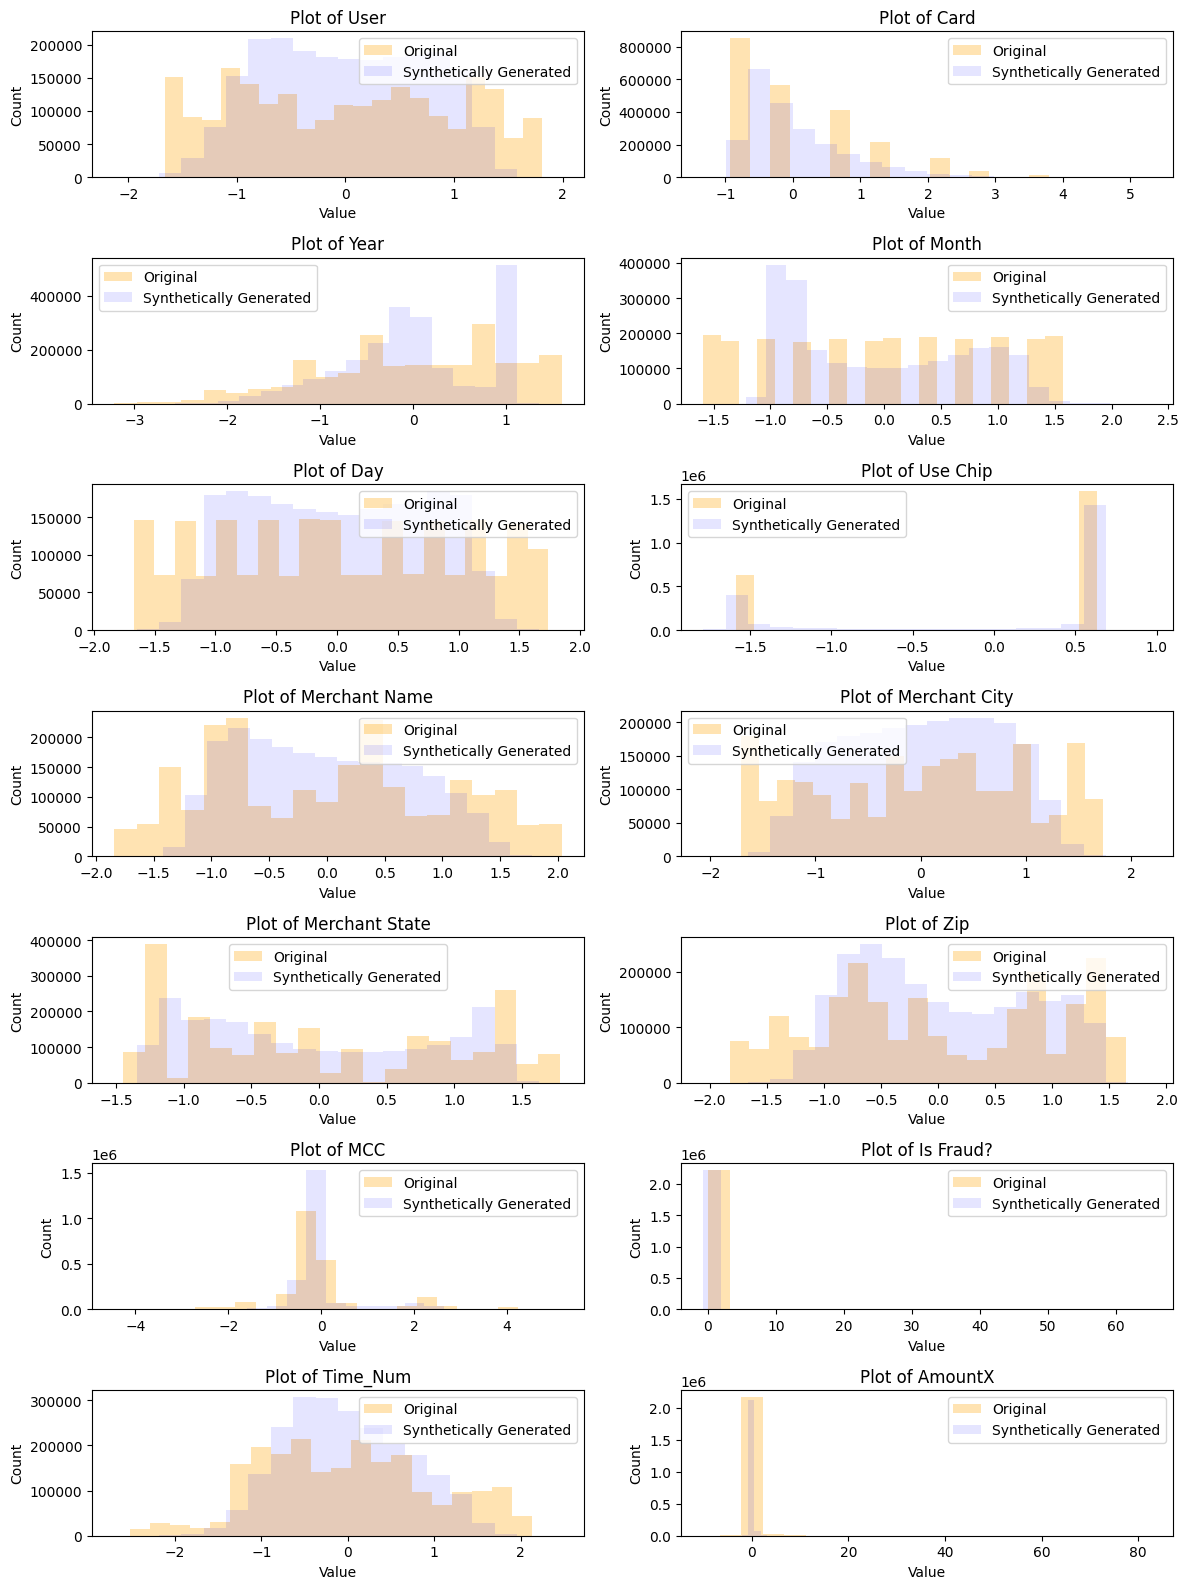

In [63]:
import matplotlib.pyplot as plt
import numpy as np

num_histograms = len(df.columns)

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 16))
axs = axs.flatten()

for i in range(num_histograms):
    axs[i].hist(df[df.columns[i]].values, bins=20, color='orange', alpha=0.3, label='Original')
    
    # axs[i].hist(scale_value(generated_df[df.columns[i]].values), bins=20, color='blue', alpha=0.1, label='Histogram 2')
    axs[i].hist(generated_df[df.columns[i]].values, bins=20, color='blue', alpha=0.1, label='Synthetically Generated')
    
    axs[i].set_title(f'Plot of {df.columns[i]}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')
    axs[i].legend()

for i in range(num_histograms, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [64]:
colList = list(df.columns)

In [65]:
def mse(y_true, y_pred):
    return np.mean(np.square(np.sort(y_true) - np.sort(y_pred)))

MSE

In [66]:
MSEs = []

for i in list(df.columns):
    mseVal = mse(df[i].values, generated_df[i].values)
    print(f"MSE for {i}:", mseVal)
    MSEs.append(mseVal)
MSEs = np.array(MSEs)

MSE for User: 0.07888499225185071
MSE for Card: 0.1241171788525953
MSE for Year: 0.07942260899958153
MSE for Month: 0.08670294607826942
MSE for Day: 0.08534815134504396
MSE for Use Chip: 0.05695074594676189
MSE for Merchant Name: 0.08395625398583577
MSE for Merchant City: 0.08271708899135528
MSE for Merchant State: 0.025065305874449037
MSE for Zip: 0.07549714660994937
MSE for MCC: 0.15451123844783424
MSE for Is Fraud?: 0.7363753313656614
MSE for Time_Num: 0.09374510685238037
MSE for AmountX: 0.391365749362075


In [ ]:
print(f'MSE for the entire data: {np.mean(MSEs)}')

In [68]:
for i in list(df.columns):
    if len(list(df[i].unique()))<50:
        print(f'{df[i].unique()}, {i}')

[-0.93270616 -0.19355703  0.54559211  1.28474124  2.02389038  2.76303951
  3.50218865  4.24133778  4.98048691], Card
[-1.8679139  -1.67527281 -1.48263172 -1.28999064 -1.09734955 -0.90470846
 -0.71206737 -0.51942628 -0.32678519 -0.1341441   0.05849699  0.25113808
  0.44377917  0.63642025  0.82906134  1.02170243  1.21434352  1.40698461
  1.5996257  -2.44583717 -2.25319608 -2.06055499 -2.63847826 -3.02376044
 -2.83111935 -3.21640152], Year
[ 0.71258382  1.00050188  1.28841993  1.57633798 -1.59076061 -1.30284255
 -1.0149245  -0.72700645 -0.43908839 -0.15117034  0.13674772  0.42466577], Month
[-1.67438307 -1.56057901 -1.44677495 -1.3329709  -1.21916684 -1.10536278
 -0.99155872 -0.87775467 -0.76395061 -0.65014655 -0.53634249 -0.42253843
 -0.30873438 -0.19493032 -0.08112626  0.0326778   0.14648185  0.26028591
  0.37408997  0.48789403  0.60169808  0.71550214  0.8293062   0.94311026
  1.05691432  1.17071837  1.28452243  1.39832649  1.51213055  1.6259346
  1.73973866], Day
[ 0.63002442 -1.587240

### Quantizing Synthetic Data

Quantizing synthetic data values whose categories are < 50

In [69]:
def round_to_nearest(value, value_list):
    return value_list[np.abs(value_list - value).argmin()]

In [70]:
def returnQuantized(df,dfGen):
    colstoQuantize = ['Card', 'Year', 'Month', 'Day', 'Use Chip', 'Is Fraud?']

    quantized_dfGen = dfGen

    for i in tqdm(colstoQuantize):
        x = dfGen[i].values
        value_list = list(df[i].unique())
        rounded_values = np.array([round_to_nearest(value=val, value_list=value_list) for val in x])
        quantized_dfGen[i] = rounded_values
    return quantized_dfGen

In [71]:
qdf = returnQuantized(df, generated_df)

100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


In [72]:
qdf

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0.523296,1.284741,-1.482632,0.136748,0.260286,0.630024,-0.633378,-1.187820,-0.236394,-0.394712,-0.182744,-0.015361,1.377787,0.047769
1,1.166427,-0.193557,-0.519426,0.712584,0.943110,0.630024,1.225469,1.219392,-0.898502,0.234330,-0.097091,-0.015361,-0.386160,-0.322100
2,1.091526,-0.193557,0.443779,-0.727006,-1.105363,0.630024,0.558918,0.915053,-0.738094,-0.146854,-0.178912,-0.015361,-0.279386,-0.318427
3,1.144131,0.545592,0.443779,-0.727006,-0.194930,0.630024,-0.860949,0.657257,0.630991,-1.184758,0.551541,-0.015361,-0.329215,-0.028550
4,-0.581870,-0.193557,-0.519426,0.712584,-0.991559,0.630024,0.734733,0.983883,-1.152615,1.247961,-0.215834,-0.015361,1.446201,0.079011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216980,0.799245,0.545592,-1.289991,-0.151170,-0.536342,0.630024,-0.627679,0.176549,0.890725,-1.133490,-0.118005,-0.015361,-1.460129,0.011456
2216981,-0.732365,0.545592,1.021702,0.136748,-0.991559,-1.587240,-1.098408,0.113860,-0.563460,-0.511015,-0.353607,-0.015361,0.715999,-0.008818
2216982,-0.433777,2.763040,-0.904708,-1.014924,0.487894,0.630024,0.004882,-0.204900,-0.813089,-0.430127,-0.344087,-0.015361,-0.635471,-0.193146
2216983,1.068834,-0.932706,-1.675273,1.288420,0.715502,0.630024,0.784508,-0.553928,0.488710,-1.047383,-0.211576,-0.015361,-0.258272,-0.066971


In [73]:
qdf.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Use Chip', 'Merchant Name',
       'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Is Fraud?',
       'Time_Num', 'AmountX'],
      dtype='object')

In [74]:
qdf.to_csv('dataset/generated_qdf_data_770.csv')

#### Comparing the quantised data with the original data

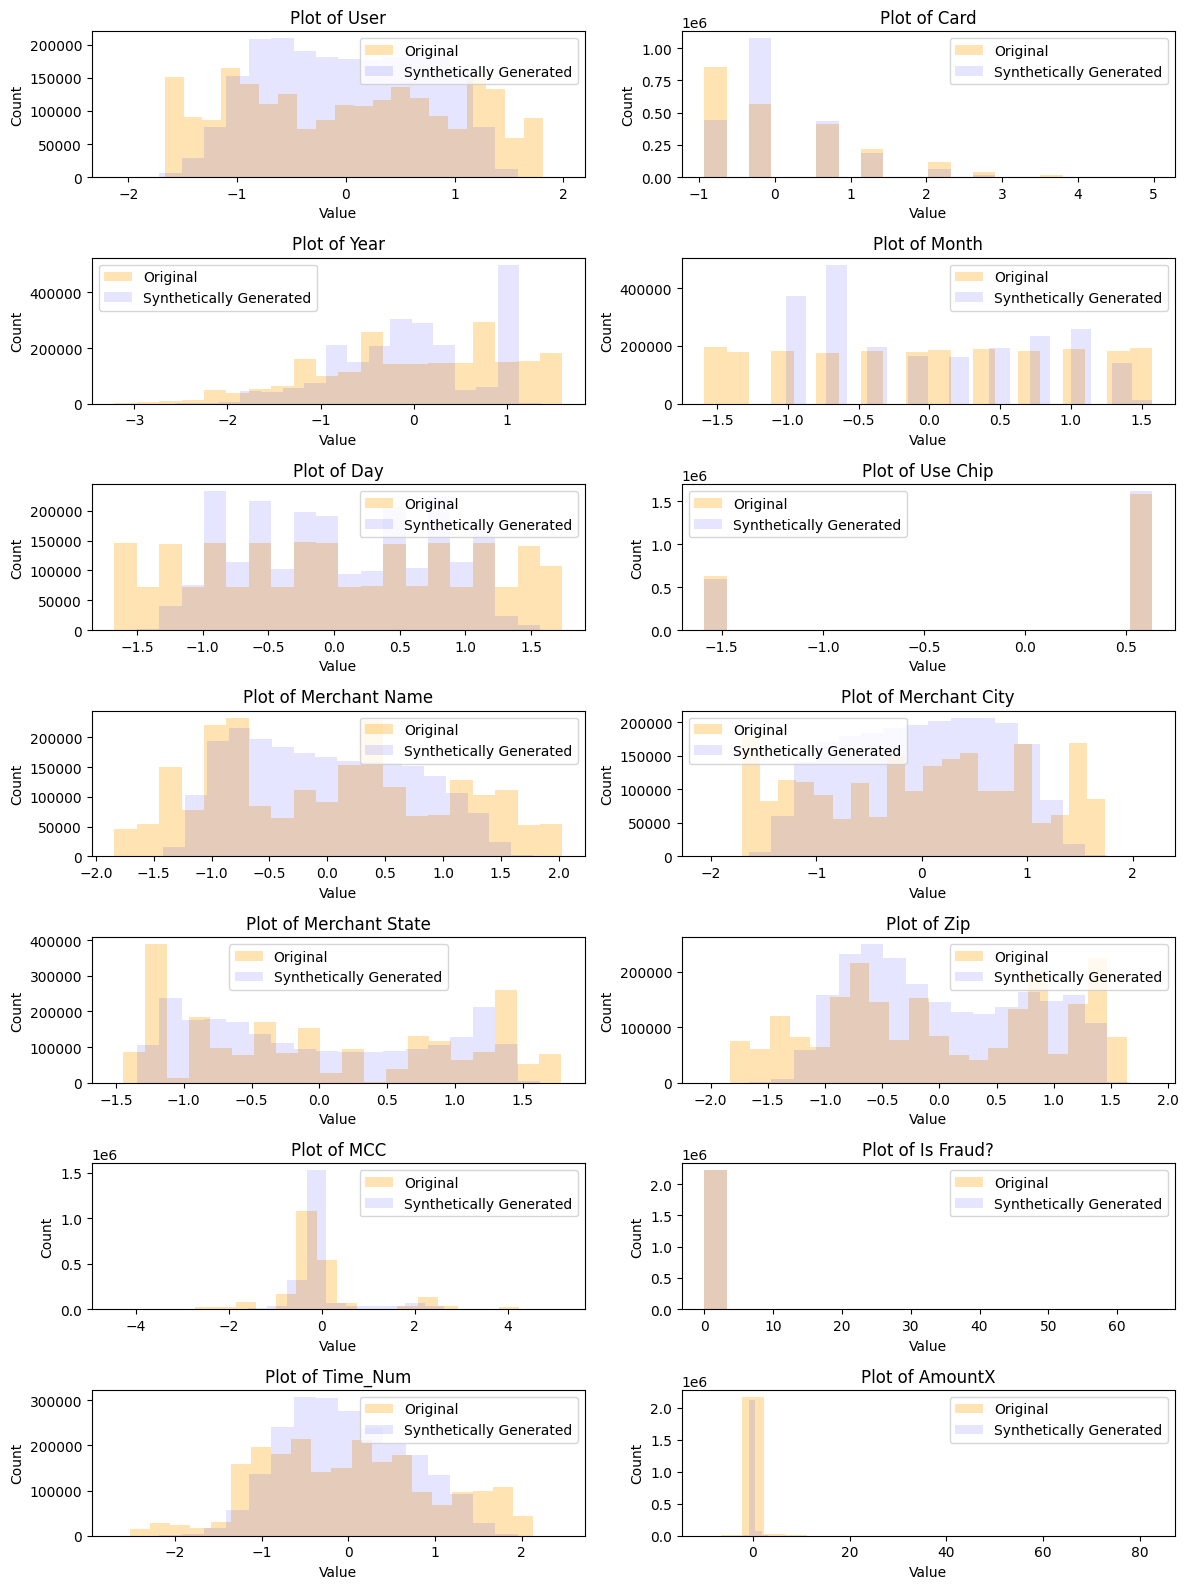

In [75]:
import matplotlib.pyplot as plt
import numpy as np

num_histograms = len(df.columns)

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 16))
axs = axs.flatten()

for i in range(num_histograms):
    axs[i].hist(df[df.columns[i]].values, bins=20, color='orange', alpha=0.3, label='Original')
    axs[i].hist(qdf[df.columns[i]].values, bins=20, color='blue', alpha=0.1, label='Synthetically Generated')

    axs[i].set_title(f'Plot of {df.columns[i]}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')
    axs[i].legend()

for i in range(num_histograms, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [76]:
MSEs = []

for i in list(df.columns):
    mseVal = mse(df[i].values, qdf[i].values)
    print(f"MSE for {i}:", mseVal)
    MSEs.append(mseVal)
MSEs = np.array(MSEs)

MSE for User: 0.07888499225185071
MSE for Card: 0.19456861081680632
MSE for Year: 0.08518347278300652
MSE for Month: 0.08747923153571854
MSE for Day: 0.08649727449358426
MSE for Use Chip: 0.0702695347302554
MSE for Merchant Name: 0.08395625398583577
MSE for Merchant City: 0.08271708899135528
MSE for Merchant State: 0.025065305874449037
MSE for Zip: 0.07549714660994937
MSE for MCC: 0.15451123844783424
MSE for Is Fraud?: 0.9944984704604249
MSE for Time_Num: 0.09374510685238037
MSE for AmountX: 0.391365749362075


In [ ]:
print(f'MSE for the entire data: {np.mean(MSEs)}')

#### Coarse-grained evaluation

In [78]:
train_df = pd.read_csv('dataset/Good_Final.csv')
generated_df = pd.read_csv('dataset/generated_data_770.csv')
generated_qdf = pd.read_csv('dataset/generated_qdf_data_770.csv')

In [79]:
fullData = pd.concat([train_df, generated_df])

In [80]:
dup_total = len(fullData) - len(fullData.drop_duplicates())

In [81]:
dup_real = len(train_df) - len(train_df.drop_duplicates())

In [82]:
dup_real

0

In [83]:
dup_synthetic = len(generated_df) - len(generated_df.drop_duplicates())

In [84]:
dup_synthetic

0

In [85]:
dup_total

0

In [86]:
copies = dup_total - dup_real - dup_synthetic

In [87]:
f'dup_total = {dup_total}, dup_real = {dup_real}'

'dup_total = 0, dup_real = 0'

In [88]:
copies

0

Percentage of duplicate values in the generated data


In [89]:
print(f'% of synthetic data is a self copy in: {((len(generated_df) - len(generated_df.drop_duplicates())) / len(generated_df))*100}')

% of synthetic data is a self copy in: 0.0


#### Medium-grained evaluation

In [90]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

def calculate_kl_divergence(data_p, data_q):
    kl_div = entropy(data_p, data_q)
    return kl_div

def calc_hist(data, bins=100):
    hist, bins = np.histogram(data, bins=bins, density=True)
    return hist, bins

train_df = pd.read_csv('dataset/Good_Final.csv')
generated_df = pd.read_csv('dataset/generated_qdf_data_770.csv')

train_data = train_df.to_numpy().flatten()
generated_data = generated_df.to_numpy().flatten()

train_hist, train_bins = calc_hist(train_data)
gen_hist, gen_bins = calc_hist(generated_data)

kl_div = calculate_kl_divergence(train_hist, gen_hist)
print("KL Divergence between the original and synthetic dataset:", kl_div)

KL Divergence between the original and synthetic dataset: 0.13847905177655478
